# Himalayan Climbing Expeditions

[TidyTuesday 2020-09-22](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-09-22)

**Contents:**

* [Setup and data load](#Setup-and-data-load)
* [Success / survival predictive features](#Success-/-survival-predictive-features)
* [Encode for modeling](#Encode-for-modeling)
* [Where do climbers come from?](#Where-do-climbers-come-from?)

## Setup and data load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, linear_model, metrics

import geopandas as gpd
import pycrs
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
base_url = 'https://github.com/rfordatascience/tidytuesday/raw/master/data/2020/2020-09-22'
expeditions = pd.read_csv(f'{base_url}/expeditions.csv')
members = pd.read_csv(f'{base_url}/members.csv')
peaks = pd.read_csv(f'{base_url}/peaks.csv')

In [4]:
print(expeditions.shape)
expeditions.head()

(10364, 16)


,expedition_id,peak_id,peak_name,year,season,basecamp_date,highpoint_date,termination_date,termination_reason,highpoint_metres,members,member_deaths,hired_staff,hired_staff_deaths,oxygen_used,trekking_agency
0,ANN260101,ANN2,Annapurna II,1960,Spring,1960-03-15,1960-05-17,NaN,Success (main peak),7937.0,10,0,9,0,True,NaN
1,ANN269301,ANN2,Annapurna II,1969,Autumn,1969-09-25,1969-10-22,1969-10-26,Success (main peak),7937.0,10,0,0,0,False,NaN
2,ANN273101,ANN2,Annapurna II,1973,Spring,1973-03-16,1973-05-06,NaN,Success (main peak),7937.0,6,0,8,0,False,NaN
3,ANN278301,ANN2,Annapurna II,1978,Autumn,1978-09-08,1978-10-02,1978-10-05,"Bad weather (storms, high winds)",7000.0,2,0,0,0,False,NaN
4,ANN279301,ANN2,Annapurna II,1979,Autumn,NaN,1979-10-18,1979-10-20,"Bad weather (storms, high winds)",7160.0,3,0,0,0,False,NaN


In [5]:
print(members.shape)
members.head()

(76519, 21)


,expedition_id,member_id,peak_id,peak_name,year,season,sex,age,citizenship,expedition_role,hired,highpoint_metres,success,solo,oxygen_used,died,death_cause,death_height_metres,injured,injury_type,injury_height_metres
0,AMAD78301,AMAD78301-01,AMAD,Ama Dablam,1978,Autumn,M,40.0,France,Leader,False,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN
1,AMAD78301,AMAD78301-02,AMAD,Ama Dablam,1978,Autumn,M,41.0,France,Deputy Leader,False,6000.0,False,False,False,False,NaN,NaN,False,NaN,NaN
2,AMAD78301,AMAD78301-03,AMAD,Ama Dablam,1978,Autumn,M,27.0,France,Climber,False,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN
3,AMAD78301,AMAD78301-04,AMAD,Ama Dablam,1978,Autumn,M,40.0,France,Exp Doctor,False,6000.0,False,False,False,False,NaN,NaN,False,NaN,NaN
4,AMAD78301,AMAD78301-05,AMAD,Ama Dablam,1978,Autumn,M,34.0,France,Climber,False,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN


In [6]:
print(peaks.shape)
peaks.head()

(468, 8)


,peak_id,peak_name,peak_alternative_name,height_metres,climbing_status,first_ascent_year,first_ascent_country,first_ascent_expedition_id
0,AMAD,Ama Dablam,Amai Dablang,6814,Climbed,1961.0,"New Zealand, USA, UK",AMAD61101
1,AMPG,Amphu Gyabjen,NaN,5630,Climbed,1953.0,UK,AMPG53101
2,ANN1,Annapurna I,NaN,8091,Climbed,1950.0,France,ANN150101
3,ANN2,Annapurna II,NaN,7937,Climbed,1960.0,"UK, Nepal",ANN260101
4,ANN3,Annapurna III,NaN,7555,Climbed,1961.0,India,ANN361101


## Success / survival predictive features

In [7]:
D = members['peak_id year season sex age citizenship expedition_role solo oxygen_used success died injured'.split()]
D = D.merge(peaks['peak_id height_metres'.split()], on='peak_id').drop(columns='peak_id')
D

,year,season,sex,age,citizenship,expedition_role,solo,oxygen_used,success,died,injured,height_metres
0,1978,Autumn,M,40.0,France,Leader,False,False,False,False,False,6814
1,1978,Autumn,M,41.0,France,Deputy Leader,False,False,False,False,False,6814
2,1978,Autumn,M,27.0,France,Climber,False,False,False,False,False,6814
3,1978,Autumn,M,40.0,France,Exp Doctor,False,False,False,False,False,6814
4,1978,Autumn,M,34.0,France,Climber,False,False,False,False,False,6814
...,...,...,...,...,...,...,...,...,...,...,...,...
76499,2019,Spring,M,31.0,Nepal,H-A Worker,False,False,True,False,False,6151
76500,2019,Spring,M,35.0,Nepal,H-A Worker,False,False,True,False,False,6151
76501,2019,Spring,M,56.0,Austria,Leader,False,False,True,False,False,6452
76502,2019,Spring,F,57.0,Austria,Climber,False,False,False,False,False,6452


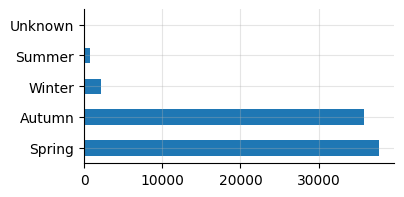

In [8]:
D.season.value_counts().plot.barh(figsize=(4,2)).grid()

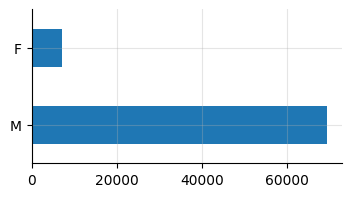

In [9]:
D.sex.value_counts().plot.barh(figsize=(4,2)).grid()

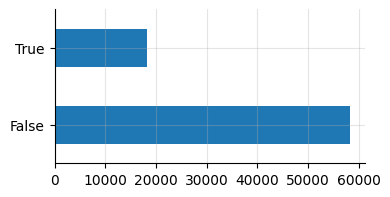

In [10]:
D.oxygen_used.value_counts().plot.barh(figsize=(4,2)).grid()

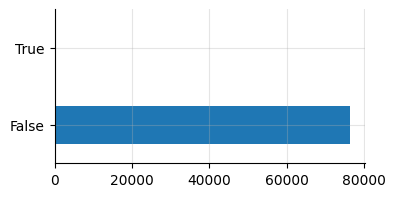

In [11]:
D.solo.value_counts().plot.barh(figsize=(4,2)).grid()

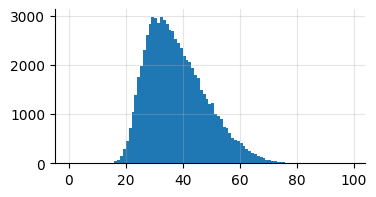

In [12]:
D.age.hist(bins=np.r_[:100], figsize=(4,2));

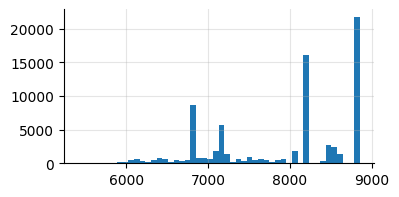

In [13]:
D.height_metres.hist(bins=50, figsize=(4,2));

In [14]:
D.expedition_role.nunique(), D.citizenship.nunique()

(524, 212)

0.9791685725114024


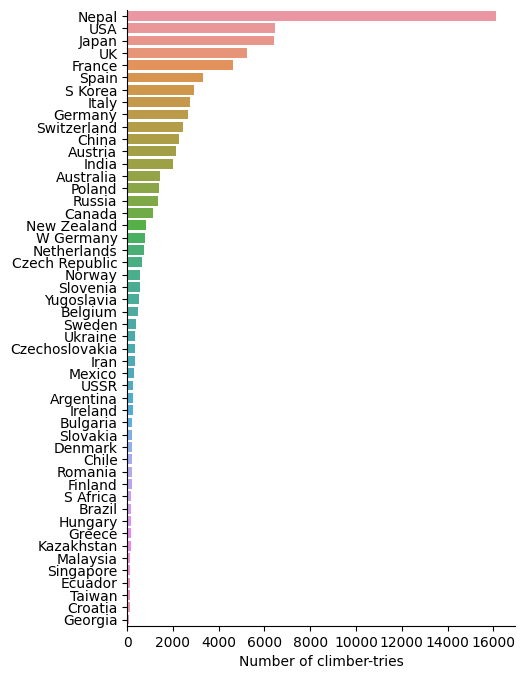

In [15]:
d = D.citizenship.value_counts().sort_values(ascending=False).reset_index().head(50)
print(d.citizenship.sum() / len(members))
fig, ax = plt.subplots(figsize=(5,8))
sns.barplot('citizenship', 'index', data=d, ax=ax)
ax.set(xlabel='Number of climber-tries', ylabel='');

## Encode for modeling

Start with numerical and binary features, then manually one-hot encode categoricals:

In [16]:
d = D.dropna()
targets = 'success injured died'.split()
XY = d[targets + 'year age height_metres oxygen_used'.split()].copy()
for c in 'season sex citizenship'.split():
    for value in D[c].value_counts().sort_values(ascending=False).head(20).index:
        XY[f'{c}_is_{value}'] = D[c].eq(value)
predictors = XY.columns[len(targets):]
XY

,success,injured,died,year,age,height_metres,oxygen_used,season_is_Spring,season_is_Autumn,season_is_Winter,season_is_Summer,season_is_Unknown,sex_is_M,sex_is_F,citizenship_is_Nepal,citizenship_is_USA,citizenship_is_Japan,citizenship_is_UK,citizenship_is_France,citizenship_is_Spain,citizenship_is_S Korea,citizenship_is_Italy,citizenship_is_Germany,citizenship_is_Switzerland,citizenship_is_China,citizenship_is_Austria,citizenship_is_India,citizenship_is_Australia,citizenship_is_Poland,citizenship_is_Russia,citizenship_is_Canada,citizenship_is_New Zealand,citizenship_is_W Germany,citizenship_is_Netherlands
0,False,False,False,1978,40.0,6814,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,1978,41.0,6814,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,1978,27.0,6814,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,1978,40.0,6814,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,1978,34.0,6814,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76499,True,False,False,2019,31.0,6151,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
76500,True,False,False,2019,35.0,6151,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
76501,True,False,False,2019,56.0,6452,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
76502,False,False,False,2019,57.0,6452,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [17]:
XYtrain, XYtest = model_selection.train_test_split(XY.sort_values('year'), test_size=.1, shuffle=False)
Xtrain, Xtest = XYtrain.drop(columns=targets), XYtest.drop(columns=targets)
XYtrain.year.min(), XYtrain.year.max(), XYtest.year.min(), XYtest.year.max()

(1905, 2016, 2016, 2019)

In [18]:
models = {
    target: linear_model.LogisticRegressionCV(solver='liblinear').fit(Xtrain, XYtrain[target])
    for target in targets
}

In [19]:
for (target, model) in models.items():
    print(target)
    print(metrics.classification_report(XYtest[target], model.predict(Xtest),
                                        zero_division=0))
    print()

success
              precision    recall  f1-score   support

       False       0.71      0.73      0.72      2621
        True       0.85      0.83      0.84      4678

    accuracy                           0.79      7299
   macro avg       0.78      0.78      0.78      7299
weighted avg       0.80      0.79      0.80      7299


injured
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      7159
        True       0.00      0.00      0.00       140

    accuracy                           0.98      7299
   macro avg       0.49      0.50      0.50      7299
weighted avg       0.96      0.98      0.97      7299


died
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      7243
        True       0.00      0.00      0.00        56

    accuracy                           0.99      7299
   macro avg       0.50      0.50      0.50      7299
weighted avg       0.98      0.99      0.99      72

In [20]:
{
    target: metrics.roc_auc_score(XYtest[target], model.predict_proba(Xtest)[:,1])
    for (target, model) in models.items()
}

{'success': 0.838888681366129,
 'injured': 0.5422510127112725,
 'died': 0.4528954064022406}

It turns out it was pretty silly to try to predict injury or death – those outcomes are simply too rare, especially in recent times.  Success has also been on the rise, but it was always common enough to appear in both the train and test sets.

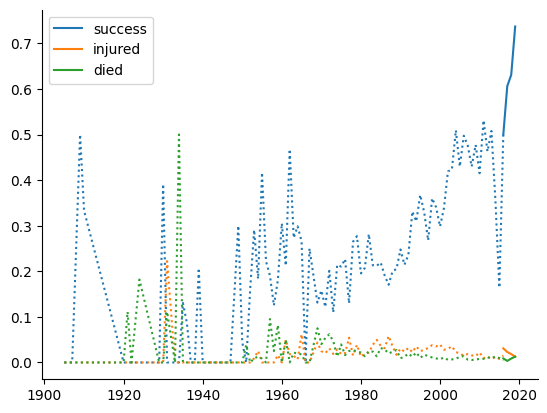

In [21]:
fig, ax = plt.subplots()
for (i, target) in enumerate(targets):
    color = f'C{i}'
    ax.plot(XYtrain.groupby('year')[target].mean(), color=color, ls=':')
    ax.plot(XYtest.groupby('year')[target].mean(), color=color, label=target)
ax.legend();

We can inspect the features used in the predictions:

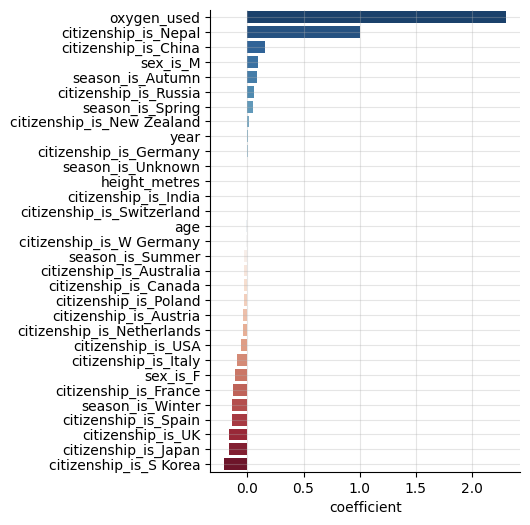

In [22]:
d = pd.DataFrame(dict(c=models['success'].coef_[0], name=predictors))
d = d.sort_values('c', ascending=False)

fig, ax = plt.subplots(figsize=(4,6))
sns.barplot('c', 'name', data=d, ax=ax,
            palette=sns.color_palette("RdBu_r", len(d)))
ax.set(xlabel='coefficient', ylabel='')
ax.grid()

Oxygen use seems to be the best predictor of success.

## Where do climbers come from?

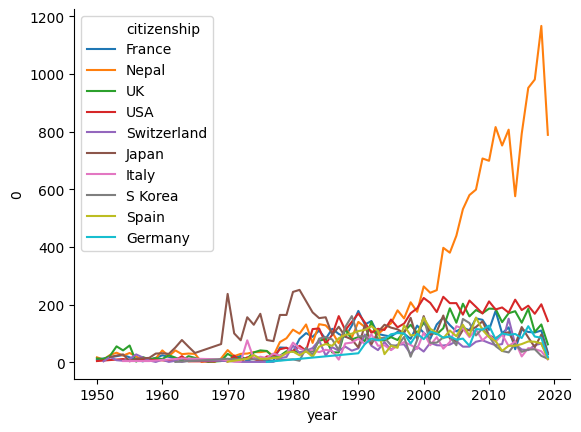

In [23]:
d = D[D.year.ge(1950) & D.citizenship.isin(D.citizenship.value_counts().head(10).index)]
ax = sns.lineplot('year', 0, 'citizenship', data=d.groupby('year citizenship'.split()).size().reset_index())
#ticks, labels = ax.get_xticks(), ax.get_xticklabels()
#ax.set(xticks=ticks[::10], xticklabels=labels[::10]);

Set up world geometry...

In [24]:
# base geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = {'init': 'epsg:4326'}

# add boundary
lons, lats = np.linspace(-180, 180, 100), np.linspace(-90, 90, 100)
boundary = Polygon(
    [(lon, -90) for lon in lons]
    + [(180, lat) for lat in lats]
    + [(lon, 90) for lon in reversed(lons)]
    + [(-180, lat) for lat in reversed(lats)])
bworld = world.append(pd.Series(dict(
    continent='Border', iso_a3='boundary', geometry=boundary)), ignore_index=True)

# project
# 54030: Robertson
pworld = bworld.to_crs(pycrs.parse.from_esri_code(54030).to_proj4())

/Users/mrichman/ve/main/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


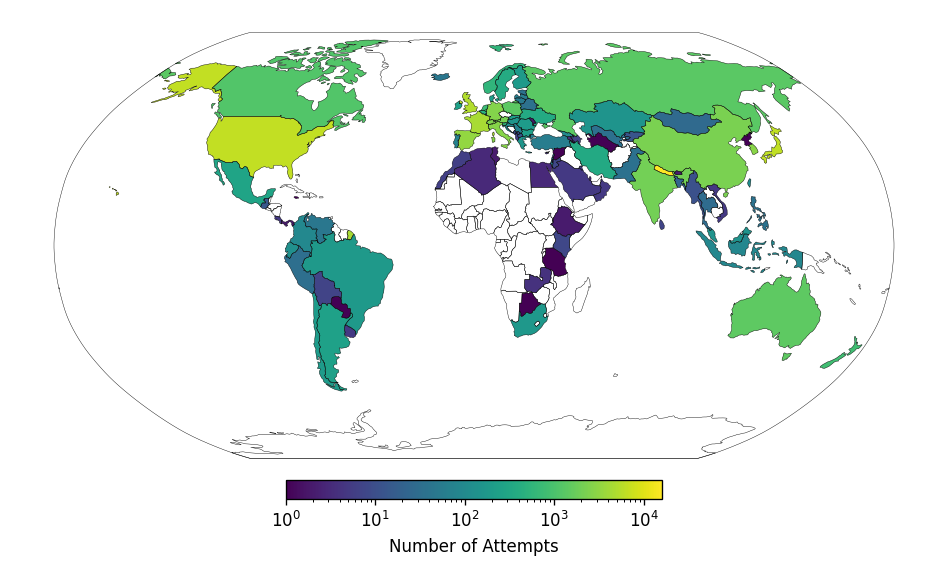

In [25]:
fig, ax = plt.subplots(figsize=(8,6), dpi=120)

c = pd.Series('/'.join(members.citizenship.dropna().astype(str)).split('/'))
c = (
    c.str.replace('USA', 'United States of America')
    .str.replace('^N ', 'North ')
    .str.replace('^S ', 'South ')
    .str.replace('^E ', 'East ')
    .str.replace('^W ', 'West ')
    .str.replace('^UK$', 'United Kingdom')
)
dd = d = c.value_counts().reset_index()
d.columns = 'name N'.split()
d = pworld.merge(d, on='name', how='left').fillna(0)
pworld.boundary.plot(color='k', lw=.25, ax=ax)
d.plot(
    'N', ax=ax,
    norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=d.N.max()),
    legend=True, legend_kwds=dict(
        orientation='horizontal', fraction=.03, pad=0, ax=ax,
        label='Number of Attempts',
    ),
)
ax.axis('off')
plt.tight_layout()

## The peaks

In [26]:
peaks.sort_values('height_metres', ascending=False).head()

,peak_id,peak_name,peak_alternative_name,height_metres,climbing_status,first_ascent_year,first_ascent_country,first_ascent_expedition_id
42,EVER,Everest,"Sagarmatha, Chomolungma, Qomolungma",8850,Climbed,1953.0,"New Zealand, India",EVER53101
91,KANG,Kangchenjunga,NaN,8586,Climbed,1955.0,UK,KANG55101
112,LHOT,Lhotse,NaN,8516,Climbed,1956.0,Switzerland,LHOT56101
188,YALU,Yalung Kang,Yalungkar,8505,Climbed,1973.0,Japan,YALU73101
122,MAKA,Makalu,NaN,8485,Climbed,1955.0,France,MAKA55101


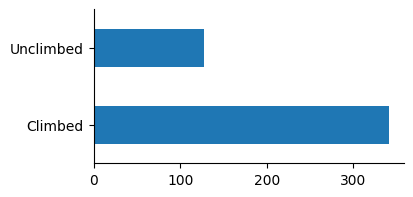

In [27]:
peaks.climbing_status.value_counts().plot.barh(figsize=(4,2));

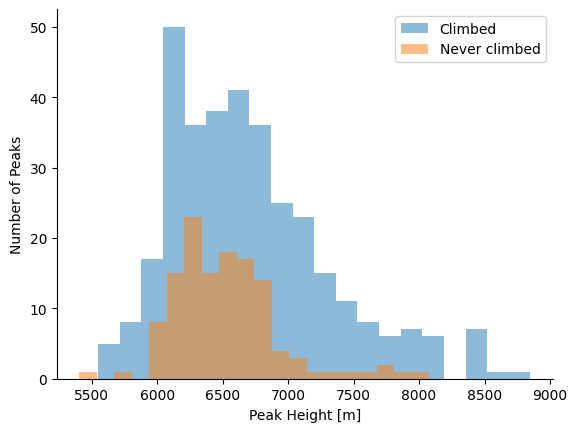

In [28]:
fig, ax = plt.subplots()
mask = peaks.climbing_status.eq('Climbed')
ax.hist(peaks.height_metres[mask], bins=20, alpha=.5, label='Climbed')
ax.hist(peaks.height_metres[~mask], bins=20, alpha=.5, label='Never climbed')
ax.legend()
ax.set(xlabel='Peak Height [m]', ylabel='Number of Peaks');

In [29]:
peaks.first_ascent_year.min()

201.0

In [30]:
peaks.loc[peaks.first_ascent_year.eq(201), 'first_ascent_year'] = 2010

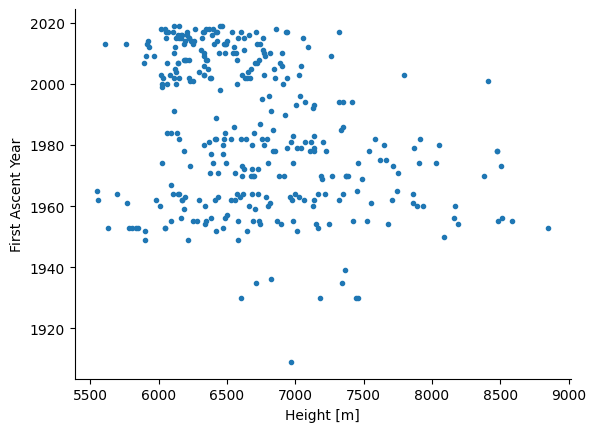

In [31]:
fig, ax = plt.subplots()
ax.plot(peaks.height_metres, peaks.first_ascent_year, '.')
ax.set(xlabel='Height [m]', ylabel='First Ascent Year');

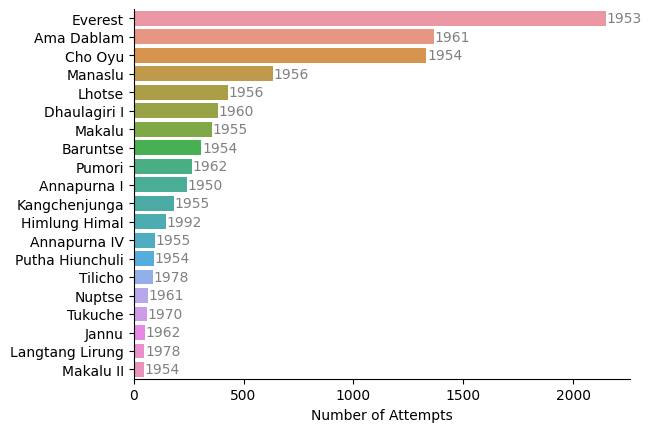

In [32]:
d = expeditions.peak_id.value_counts().reset_index().head(20)
d.columns = 'peak_id counts'.split()
d = d.merge(peaks, on='peak_id')
ax = sns.barplot('counts', 'peak_name', data=d)
for (i, row) in d.iterrows():
    ax.text(row.counts+3, i, f'{int(row.first_ascent_year)}', va='center', color='.5')
ax.set(xlabel='Number of Attempts', ylabel='');